### semantic search engine over a PDF document

In [8]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [2]:
# pdf document loading
from langchain_community.document_loaders import PyPDFLoader

file_path = "nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

107


In [3]:
#accessing information on loaded docs
print(f"{docs[0].page_content[:200]}\n")


Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
F



In [4]:
print(docs[0].metadata)

{'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': 'nke-10k-2023.pdf', 'total_pages': 107, 'page': 0, 'page_label': '1'}


In [5]:
#splitting texts into chuncks of 1000
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

516

In [6]:
#vector embeding
from langchain_google_vertexai import VertexAIEmbeddings

embeddings = VertexAIEmbeddings(model="text-embedding-004")

In [7]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 768

[0.025028448551893234, 0.021236900240182877, 0.0674874484539032, 0.04534987360239029, 0.018470225855708122, 0.030282137915492058, 0.05763626843690872, 0.012206651270389557, -0.025709806010127068, -0.03336406499147415]


In [9]:
#vector store
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [10]:
ids = vector_store.add_documents(documents=all_splits)

In [14]:
results = vector_store.similarity_search(
    "How many distribution centers does Nike have in the US?"
)

print(results[0])

page_content='operations. We also lease an office complex in Shanghai, China, our headquarters for our Greater China geography, occupied by employees focused on implementing our
wholesale, NIKE Direct and merchandising strategies in the region, among other functions.
In the United States, NIKE has eight significant distribution centers. Five are located in or near Memphis, Tennessee, two of which are owned and three of which are
leased. Two other distribution centers, one located in Indianapolis, Indiana and one located in Dayton, Tennessee, are leased and operated by third-party logistics
providers. One distribution center for Converse is located in Ontario, California, which is leased. NIKE has a number of distribution facilities outside the United States,
some of which are leased and operated by third-party logistics providers. The most significant distribution facilities outside the United States are located in Laakdal,' metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 

In [16]:
# asynchronous
results = await vector_store.asimilarity_search("When was Nike incorporated?")

print(results[0])

page_content='Table of Contents
PART I
ITEM 1. BUSINESS
GENERAL
NIKE, Inc. was incorporated in 1967 under the laws of the State of Oregon. As used in this Annual Report on Form 10-K (this "Annual Report"), the terms "we," "us," "our,"
"NIKE" and the "Company" refer to NIKE, Inc. and its predecessors, subsidiaries and affiliates, collectively, unless the context indicates otherwise.
Our principal business activity is the design, development and worldwide marketing and selling of athletic footwear, apparel, equipment, accessories and services. NIKE is
the largest seller of athletic footwear and apparel in the world. We sell our products through NIKE Direct operations, which are comprised of both NIKE-owned retail stores
and sales through our digital platforms (also referred to as "NIKE Brand Digital"), to retail accounts and to a mix of independent distributors, licensees and sales' metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'cr

C:\Users\JHAMMOND\AppData\Local\Temp\ipykernel_26360\1736401047.py:2: RuntimeWarning: coroutine 'InMemoryVectorStore.asimilarity_search' was never awaited
  results = await vector_store.asimilarity_search("When was Nike incorporated?")


In [18]:
# scoring
# Note that providers implement different scores; the score here
# is a distance metric that varies inversely with similarity.

results = vector_store.similarity_search_with_score("What was Nike's revenue in 2023?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 0.7558784352892262

page_content='Table of Contents
FISCAL 2023 NIKE BRAND REVENUE HIGHLIGHTSThe following tables present NIKE Brand revenues disaggregated by reportable operating segment, distribution channel and major product line:
FISCAL 2023 COMPARED TO FISCAL 2022
• NIKE, Inc. Revenues were $51.2 billion in fiscal 2023, which increased 10% and 16% compared to fiscal 2022 on a reported and currency-neutral basis, respectively.
The increase was due to higher revenues in North America, Europe, Middle East & Africa ("EMEA"), APLA and Greater China, which contributed approximately 7, 6,
2 and 1 percentage points to NIKE, Inc. Revenues, respectively.
• NIKE Brand revenues, which represented over 90% of NIKE, Inc. Revenues, increased 10% and 16% on a reported and currency-neutral basis, respectively. This
increase was primarily due to higher revenues in Men's, the Jordan Brand, Women's and Kids' which grew 17%, 35%,11% and 10%, respectively, on a wholesale
equivalent basis.' metad

In [17]:
# Retreiver
from typing import List

from langchain_core.documents import Document
from langchain_core.runnables import chain


@chain
def retriever(query: str) -> List[Document]:
    return vector_store.similarity_search(query, k=1)


retriever.batch(
    [
        "How many distribution centers does Nike have in the US?",
        "When was Nike incorporated?",
    ],
)

[[Document(id='9e81bf44-61c9-4e63-a674-230d4b493b4b', metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': 'nke-10k-2023.pdf', 'total_pages': 107, 'page': 26, 'page_label': '27', 'start_index': 804}, page_content='operations. We also lease an office complex in Shanghai, China, our headquarters for our Greater China geography, occupied by employees focused on implementing our\nwholesale, NIKE Direct and merchandising strategies in the region, among other functions.\nIn the United States, NIKE has eight significant distribution centers. Five are located in or near Memphis, Tennessee, two of which are owned and three of which

### AGENT

In [7]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [8]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = getpass.getpass()

 ········


In [9]:
# tool
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=2)
search_results = search.invoke("what is the weather in SF")
print(search_results)
# If we want, we can create other tools.
# Once we have all the tools we want, we can put them in a list that we will reference later.
tools = [search]

[{'title': '10-Day Weather Forecast for San Francisco, CA', 'url': 'https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US', 'content': "My DashboardTodayHourly10 DayWeekendMonthlyRadarTravel\nMore ForecastsMore\nSpecialty Forecasts\nYesterday's Weather Allergy TrackerCold & FluAir Quality Forecast\nAdvertisement\n10 Day Weather-San Francisco, CA\nAs of 11:42 am PDT\nToday\nSunny\n63°/49°\n1%\nW 15\xa0mph\nMon 28 | Day\n63°\n1%\nW 15\xa0mph\nSunny. High 63F. Winds W at 10 to 20 mph. [...] Sat 10\nMostly Sunny\n64°/49°\n8%\nW 14\xa0mph\nSat 10 | Day\n64°\n8%\nW 14\xa0mph\nMostly sunny skies. High 64F. Winds W at 10 to 20 mph.\n\n\nHumidity70%\n\n\nUV Index9 of 11\n\n\nSunrise6:04 am\n\n\nSunset8:08 pm\n\n\nSat 10 | Night\n49°\n10%\nW 13\xa0mph\nMostly clear skies. Low 49F. Winds W at 10 to 15 mph.\n\n\nHumidity86%\n\n\nUV Index0 of 11\n\n\nMoonrise6:41 pm\nWaxing Gibbous\n\n\nMoonset4:48 am\n\n\nSun 11\nPartly Cloudy\n64°/49°\n18%\nW 13\xa0mph\nSun 11 | Day\n64°\n18%\nW 13\

In [10]:
# Model
# Ensure your VertexAI credentials are configured

from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash-001", model_provider="google_vertexai")

In [11]:
from langchain_core.messages import HumanMessage

response = model.invoke([HumanMessage(content="hi!")])
response.content

'Hi there! How can I help you today?\n'

In [12]:
#tool binding
model_with_tools = model.bind_tools(tools)

In [13]:
response = model_with_tools.invoke([HumanMessage(content="Hi!")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: Hi there! How can I help you today?

ToolCalls: []


In [14]:
response = model_with_tools.invoke([HumanMessage(content="What's the weather in SF?")])

print(f"ContentString: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

ContentString: 
ToolCalls: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'fbbe4fe9-be37-4f5a-99a4-e518f0dfe28e', 'type': 'tool_call'}]


In [1]:
# Create Agent
from langchain.agents import create_react_agent

agent_executor = create_react_agent(model, tools)

NameError: name 'model' is not defined

In [3]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [10]:
class AgentState(TypedDict):
    message: str

def greeting_node(state: AgentState) -> AgentState:
    """Simple node that adds a greeting message to state"""
    
    state['message'] = "Hey " + state["message"] + ", you are doing great learning langgraph"
    return state

In [11]:
# Build Graph
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)

graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

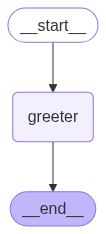

In [12]:
# a way to display graph

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
result = app.invoke({"message": "Bob"})

In [14]:
result["message"]

'Hey Bob, you are doing great learning langgraph'

In [15]:
# Multiple Inpits Graph
from typing import TypedDict, List
from langgraph.graph import StateGraph

In [17]:
class AgentState(TypedDict):
    values: List[int]
    name: str
    result: str

In [18]:
def process_values(state: AgentState) -> AgentState:
    """This function handles multiple inputs"""

    state["result"] = f"Hi there {state["name"]}! Your sum = {sum(state["values"])}"
    return state

In [21]:
graph = StateGraph(AgentState)

graph.add_node("process_value", process_values)

graph.set_entry_point("process_value")
graph.set_finish_point('process_value')

app = graph.compile()

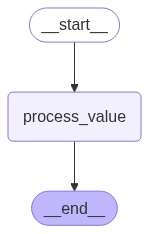

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
answers = app.invoke({"values": [1,2,3,4], "name":"Jeff"})

In [24]:
print(answers)

{'values': [1, 2, 3, 4], 'name': 'Jeff', 'result': 'Hi there Jeff! Your sum = 10'}


In [43]:
# Graph Exercise
from typing import TypedDict, List
from langgraph.graph import StateGraph
import math

In [35]:
class AgentState(TypedDict):
    name: str
    values: List[int]
    operator: str
    result: str

In [36]:
def value_processor(state: AgentState) -> AgentState:
    """This functions accepts multiple input and performs operations based on the type of operator"""

    if state["operator"] == '+':
        state['result'] = f"Hi there, {state['name']}! you result is {sum(state['values'])}"
    elif state["operator"] == '*':
        state['result'] = f"Hi there, {state['name']}! you result is {math.prod(state['values'])}"
    return state
    

In [38]:
graph = StateGraph(AgentState)

graph.add_node('processor', value_processor)

graph.set_entry_point('processor')
graph.set_finish_point('processor')

app = graph.compile()

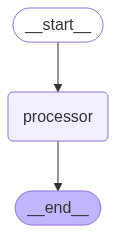

In [39]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [46]:
answers = app.invoke({"name":"Jeff", "values": [1, 2, 3, 4, 5], "operator":"+"})

In [47]:
print(answers)

{'name': 'Jeff', 'values': [1, 2, 3, 4, 5], 'operator': '+', 'result': 'Hi there, Jeff! you result is 15'}


In [48]:
from typing import TypedDict, List
from langgraph.graph import StateGraph

In [63]:
class AgentState(TypedDict):
    name: str
    age: str
    skills: List[str]
    final: str

In [98]:
def first_node(state: AgentState) -> AgentState:
    """This is the first node in the sequence"""

    state['final'] = f"Hi {state['name']}, welcome!"
    return state

def second_node(state: AgentState) -> AgentState:
    """This is the first node in the sequence"""

    state['final'] =f"{state['final']}, You are {state['age']} years old!"
    return state

def third_node(state: AgentState) -> AgentState:
    """This is the first node in the sequence"""

    state['final'] = f"{state['final']} You have sills in  {state['skills'][0]}, {state['skills'][1]} and {state['skills'][2]}"
    return state

In [99]:
graph = StateGraph(AgentState)

graph.add_node('first', first_node)
graph.add_node('second', second_node)
graph.add_node('third', third_node)
graph.set_entry_point('first')
graph.add_edge('first', 'second')
graph.add_edge('second', 'third')
graph.set_finish_point('second')

app = graph.compile()

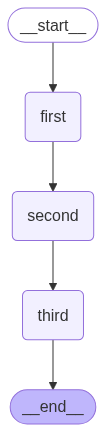

In [100]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [101]:
answers = app.invoke({'name': 'Jeff', 'age':'23', 'skills':['Python', 'Machine Learning', 'Langgraph']})

In [102]:
print(answers)

{'name': 'Jeff', 'age': '23', 'skills': ['Python', 'Machine Learning', 'Langgraph'], 'final': 'Hi Jeff, welcome!, You are 23 years old! You have sills in  Python, Machine Learning and Langgraph'}


### New Excecise
Add or Subtract

In [119]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END

In [174]:
class AgentState(TypedDict):
    number1: int
    number2: int
    number3: int
    operation1: str
    finalnumber1: int


In [175]:
def adder(state: AgentState) -> AgentState:
    """this node does addition"""
    state['finalnumber1'] = state['number1'] + state['number2']
    return state
    

def subtractor(state: AgentState) -> AgentState:
    """this node does subtraction"""
    state['finalnumber1'] = state['number1'] - state['number2']
    return state

def decide_next_node(state:AgentState) -> AgentState:
    """this node select the next step in of the graph"""

    if state['operation1'] == '+':
        return "addition_operation"
        
    elif state['operation1'] == '-':
        return "subtraction_operation"

    

In [176]:
graph = StateGraph(AgentState)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state:state) # pass through

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }
)

graph.add_edge("add_node",END)
graph.add_edge("subtract_node", END)

app = graph.compile()

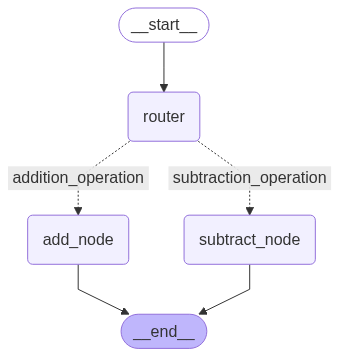

In [177]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [179]:
initial_state_1 = AgentState(number1 = 10, number2 = 5, operation1 = '+' )
print(app.invoke(initial_state_1))

{'number1': 10, 'number2': 5, 'operation1': '+', 'finalnumber1': 15}


# Excercise

In [173]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END

In [190]:
class AgentState(TypedDict):
    number1: int
    number2: int
    number3: int
    number4: int
    operation1: str
    operation2: str
    finalnumber1: int
    finalnumber2: int


In [200]:
def adder(state: AgentState) -> AgentState:
    """this node does addition"""
    state['finalnumber1'] = state['number1'] + state['number2']
    return state

def adder2(state: AgentState) -> AgentState:
    """this node does addition"""
    state['finalnumber2'] = state['number3'] + state['number4']
    return state
    

def subtractor(state: AgentState) -> AgentState:
    """this node does subtraction"""
    state['finalnumber1'] = state['number1'] - state['number2']
    return state

def subtractor2(state: AgentState) -> AgentState:
    """this node does subtraction"""
    state['finalnumber2'] = state['number3'] - state['number4']
    return state

def decide_next_node(state:AgentState) -> AgentState:
    """this node select the next step in of the graph"""

    if state['operation1'] == '+':
        return "addition_operation"
        
    elif state['operation1'] == '-':
        return "subtraction_operation"

def decide_next_node2(state:AgentState) -> AgentState:
    """this node select the next step in of the graph"""

    if state['operation2'] == '+':
        return "addition_operation"
        
    elif state['operation2'] == '-':
        return "subtraction_operation"


In [201]:
graph = StateGraph(AgentState)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("add_node2", adder2)
graph.add_node("subtract_node2", subtractor2)
graph.add_node("router", lambda state:state) # pass through
graph.add_node("router2", lambda state:state)


graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }
)

graph.add_edge("add_node","router2")
graph.add_edge("subtract_node", "router2")

graph.add_conditional_edges(
    "router2",
    decide_next_node2,
    {
        "addition_operation": "add_node2",
        "subtraction_operation": "subtract_node2"
    }
)

graph.add_edge("add_node2", END)
graph.add_edge("subtract_node2", END)

app = graph.compile()

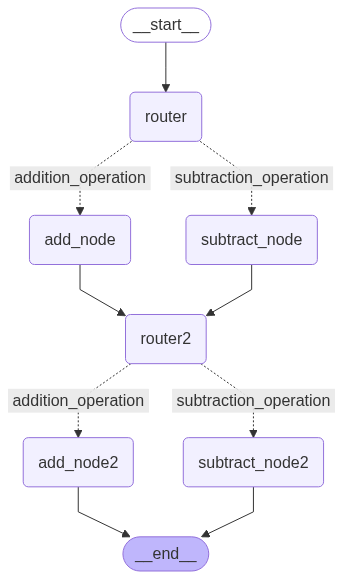

In [202]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [203]:
initial_state_2 = AgentState(number1 = 10, number2 = 5, number3 = 40, number4 = 9, operation1 = '+' , operation2 = '-')

In [204]:
print(app.invoke(initial_state_2))

{'number1': 10, 'number2': 5, 'number3': 40, 'number4': 9, 'operation1': '+', 'operation2': '-', 'finalnumber1': 15, 'finalnumber2': 31}


# Agent 5

In [13]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv # used to store secret stuff like API Keys or configuration values

In [14]:
load_dotenv()

True

In [18]:
class AgentState(TypedDict): 
    messages: List[HumanMessage]

llm = ChatVertexAI(
    model="gemini-2.5-flash-preview-04-17",
    temperature=0,
    max_tokens=None,
    max_retries=6,
    stop=None,
   
)

In [19]:
def process(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(f"\nAI: {response.content}")
    return state

In [20]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

In [ ]:
user_input = input()